In [52]:
import numpy as np
import math
import csv 
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import seaborn as sns
import os
import imageio
import colorcet as cc
import cartopy.crs as ccrs
import stripy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(12,6),"lines.markersize":2},font_scale=1.25)
sns.set_context("notebook")
sns.set_style("white")

In [288]:
def cart2sph(x, y, z):
    r = np.sqrt(np.power(x, 2) + np.power(y, 2) + np.power(z, 2))
    colat = np.arctan2(np.sqrt(np.power(x, 2) + np.power(y, 2)), z)
    lon = np.arctan2(y, x)
    return r, colat, lon

def latlon(x, y, z): # returns latitude and longitude in degrees 
    r, colat, lon = cart2sph(x, y, z)
    return lon, colat

def sph2cart(r, colat, lon):
    x = r * np.sin(colat) * np.cos(lon)
    y = r * np.sin(colat) * np.sin(lon)
    z = r * np.cos(colat)
    return x, y, z

def gcdist(p1, p2, radius):
    s = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
    theta = np.arccos(np.minimum(np.maximum(s, -1), 1))
    
    return radius * theta

In [231]:
points_count = np.zeros(101)

In [232]:
with open('fast_point_counts_rh4_40962_noamr.csv', 'r', newline='') as csvfile1:
    reader1 = csv.reader(csvfile1, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
    i = 0
    for row in reader1:
#         print(row)
        points_count[i] = row[0]
        i += 1

In [233]:
data = np.zeros((101, int(points_count.max()), 8)) # x y z vorticity passive tracer area lon colat

In [343]:
with open('fast_output_rh4_40962_noamr.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
    i = 0
    t = 0
    for row in reader:
#         t = i // point_count
#         point = i % point_count
        data[t, i, 0:6] = row
        lon, colat = latlon(*row[0:3])
        data[t, i, 6:8] = lon, math.pi / 2 - colat
        i += 1
        if (i >= points_count[t]):
            t += 1
            i = 0
#         if t >= 101:
        if t > 1:
            break

In [421]:
lats = data[0,:,7]
lons = data[0,:,6]
areas = data[0,:,5]
vor = data[0,:,3]
true_vor = 2 * math.pi / 7 * np.sin(lats) + 30 * np.sin(lats) * np.power(np.cos(lats), 4) * np.cos(4 * lons)
# true_vor=data[0,:,3]

In [422]:
np.sqrt(np.sum(np.square(true_vor - vor) * areas) / np.sum(np.square(true_vor) * areas))

1.6088600342799063e-06

In [423]:
np.sum(np.square(true_vor) * areas)

212.26916104255932

In [424]:
areas

array([0.00023719, 0.00023719, 0.00023719, ..., 0.00028465, 0.00028519,
       0.00028465])

In [425]:
lon0 = 0
lat0 = math.pi / 20

In [426]:
vor_zero = np.zeros(40962)
for i in range(40962):
    vor_zero[i] = 4 * math.pi * np.exp(-16 * np.square(gcdist(sph2cart(1, math.pi/2-lats[i], lons[i]), sph2cart(1, math.pi/2-lat0, lon0), 1)))
total_vor = np.sum(vor_zero * areas) / (4 * math.pi)
for i in range(40962):
    vor_zero[i] -= total_vor
    
    
    
    

In [427]:
np.sum(vor_zero * areas)

-1.10306399143847e-07

In [428]:
fmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=4, include_face_points=True)
resX = 720
resY = 360

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)
spherical_triangulation = stripy.sTriangulation(lons=lons, lats=lats)
interp_c2f3, err = spherical_triangulation.interpolate(fmesh.lons, fmesh.lats, order=1, zdata=vor_zero)
grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)

resX = 720
resY = 360

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)
grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)

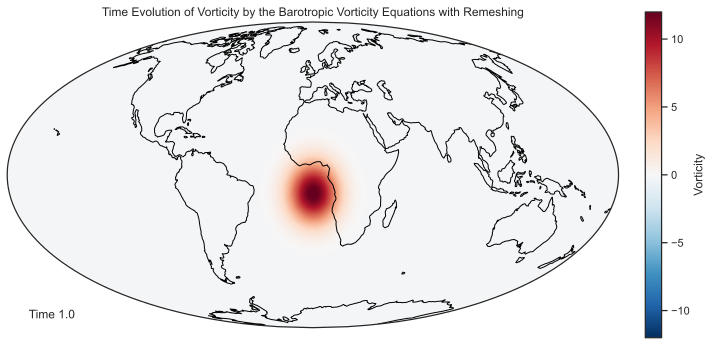

In [429]:
fig = plt.figure()
ax1  = plt.subplot(projection=ccrs.Mollweide())
ax1.coastlines()
ax1.set_global()
img = ax1.imshow(grid_z1, extent=np.degrees(extent_globe), cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-12, vmax=12)
cbar = plt.colorbar(img, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('Vorticity')
plt.title('Time Evolution of Vorticity by the Barotropic Vorticity Equations with Remeshing')
plt.figtext(0.15, 0.17, f'Time {1.00}')
plt.show()
# plt.savefig('bve_vor_t1_rh4.png')

In [329]:
np.max(vor_zero)

10.87052016598848

In [258]:
np.shape(data[0,:,0])

(40962,)

In [419]:
lats[0:10]

array([0.        , 1.10714827, 2.03444425, 1.10714841, 2.03444424,
       1.1071484 , 2.03444438, 1.10714841, 2.03444425, 1.1071484 ])

In [420]:
lons[0:10]

array([ 0.        ,  0.        ,  0.6283183 ,  1.25663734,  1.88495531,
        2.51327436,  3.14159265, -1.25663734, -0.6283183 , -2.51327436])